In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import scipy.stats as stats


In [2]:
tle_df = pd.read_csv('data/u_tle.csv')
tle_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14979 entries, 0 to 14978
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CCSDS_OMM_VERS       14979 non-null  int64  
 1   COMMENT              14979 non-null  object 
 2   CREATION_DATE        14979 non-null  object 
 3   ORIGINATOR           14979 non-null  object 
 4   OBJECT_NAME          14979 non-null  object 
 5   OBJECT_ID            14979 non-null  object 
 6   CENTER_NAME          14979 non-null  object 
 7   REF_FRAME            14979 non-null  object 
 8   TIME_SYSTEM          14979 non-null  object 
 9   MEAN_ELEMENT_THEORY  14979 non-null  object 
 10  EPOCH                14979 non-null  object 
 11  MEAN_MOTION          14979 non-null  float64
 12  ECCENTRICITY         14979 non-null  float64
 13  INCLINATION          14979 non-null  float64
 14  RA_OF_ASC_NODE       14979 non-null  float64
 15  ARG_OF_PERICENTER    14979 non-null 

In [3]:
columns_to_keep = ['OBJECT_NAME', 'NORAD_CAT_ID', 'EPOCH', 'MEAN_MOTION', 'BSTAR', 'INCLINATION', 'ECCENTRICITY', 'ARG_OF_PERICENTER', 'RA_OF_ASC_NODE', 'MEAN_ANOMALY', 'SEMIMAJOR_AXIS']
tle_filtered_df = tle_df[columns_to_keep]
tle_filtered_df

,OBJECT_NAME,NORAD_CAT_ID,EPOCH,MEAN_MOTION,BSTAR,INCLINATION,ECCENTRICITY,ARG_OF_PERICENTER,RA_OF_ASC_NODE,MEAN_ANOMALY,SEMIMAJOR_AXIS
0,NAVSTAR 58 (USA 190),29486,2024-07-01T01:12:29.109888,2.005549,0.0,54.6803,0.010344,38.4225,179.7371,333.4432,26561.118
1,NAVSTAR 58 (USA 190),29486,2024-07-01T18:27:18.089568,2.005549,0.0,54.6798,0.010345,38.4371,179.7087,132.2901,26561.121
2,NAVSTAR 58 (USA 190),29486,2024-07-02T01:08:29.000832,2.005548,0.0,54.6798,0.010345,38.4456,179.6976,333.4357,26561.122
3,NAVSTAR 58 (USA 190),29486,2024-07-03T01:03:28.760832,2.005548,0.0,54.6798,0.010346,38.4668,179.6581,332.9277,26561.126
4,NAVSTAR 58 (USA 190),29486,2024-07-03T18:25:10.727328,2.005548,0.0,54.6799,0.010347,38.4787,179.6295,135.2281,26561.129
...,...,...,...,...,...,...,...,...,...,...,...
14974,BEIDOU 3M25,61186,2025-07-09T21:10:40.912608,1.862303,0.0,54.7760,0.000355,285.0859,314.1177,75.7300,27906.262
14975,BEIDOU 3M25,61186,2025-07-10T12:17:42.319968,1.862302,0.0,54.7754,0.000357,284.7920,314.0961,138.3232,27906.266
14976,BEIDOU 3M25,61186,2025-07-10T12:17:42.319968,1.862302,0.0,54.7754,0.000357,284.7920,314.0961,138.3232,27906.266
14977,BEIDOU 3M25,61186,2025-07-11T08:40:55.780608,1.862302,0.0,54.7747,0.000359,284.6373,314.0668,347.9965,27906.270


In [4]:
tle_filtered_df.isna().sum()

OBJECT_NAME          0
NORAD_CAT_ID         0
EPOCH                0
MEAN_MOTION          0
BSTAR                0
INCLINATION          0
ECCENTRICITY         0
ARG_OF_PERICENTER    0
RA_OF_ASC_NODE       0
MEAN_ANOMALY         0
SEMIMAJOR_AXIS       0
dtype: int64

In [5]:
tle_filtered_df.isnull().sum()

OBJECT_NAME          0
NORAD_CAT_ID         0
EPOCH                0
MEAN_MOTION          0
BSTAR                0
INCLINATION          0
ECCENTRICITY         0
ARG_OF_PERICENTER    0
RA_OF_ASC_NODE       0
MEAN_ANOMALY         0
SEMIMAJOR_AXIS       0
dtype: int64

In [ ]:
tle_filtered_df.head()



Why SemiMajor Axis: 
- Primary measurement of a satellite's orbit size,
- Directly related to its altituide above Earth
- Key parameter that changes over time when orbital decay occurs (Delta A / Change in Semi-Major Axis)
- Semi-Major Axis will decrease as orbit decays, predicting shrink rate = predicting orbital decay

Why Decay Rate:
- How fast semi-major axis changes (delta A / delta T)
- Observable output for model
- Target 


In [14]:
# Define functions to convert epoch to datetime, calculate semimajor axis, and calculate decay rate

# Constants
mu = 398600.4418 # Earth's gravitational constant, needed to calculate semimajor axis, in km^3/s^2

# Convert Epoch to datetime
def convert_epoch(df):
    df['EPOCH'] = pd.to_datetime(df['EPOCH'])
    return df

# Calculate Semi-Major Axis
def calc_semimajor_axis(df):
    n = df['MEAN_MOTION'] * 2 * np.pi / 86400 # rad/s
    df['semi_major_axis_calc'] = (mu / (n ** 2)) ** (1/3) # units = km
    return df

# Calculate Decay Rate
def calc_decay_rate(df):
    df = df.sort_values(by=['OBJECT_NAME', 'EPOCH']).reset_index(drop=True)
    df['decay_rate'] = np.nan # Initialize column, units = km/day

    for sat in df['OBJECT_NAME'].unique():
        sat_df = df[df['OBJECT_NAME'] == sat].sort_values(by='EPOCH').reset_index()

        for i in range(1, len(sat_df)):
            delta_a = sat_df.loc[i, 'semi_major_axis_calc'] - sat_df.loc[i-1, 'semi_major_axis_calc']
            delta_t = (sat_df.loc[i, 'EPOCH'] - sat_df.loc[i-1, 'EPOCH']).total_seconds() / 86400 # days

            if delta_t > 0:
                decay = abs(delta_a / delta_t)
                df.loc[sat_df.loc[i, 'index'], 'decay_rate'] = decay
    return df

In [15]:
tle_filtered_df = convert_epoch(tle_filtered_df)
tle_filtered_df = calc_semimajor_axis(tle_filtered_df)
tle_filtered_df = calc_decay_rate(tle_filtered_df)
tle_filtered_df

,OBJECT_NAME,NORAD_CAT_ID,EPOCH,MEAN_MOTION,BSTAR,INCLINATION,ECCENTRICITY,ARG_OF_PERICENTER,RA_OF_ASC_NODE,MEAN_ANOMALY,SEMIMAJOR_AXIS,semi_major_axis_calc,decay_rate
0,AEHF 4 (USA 288),43651,2024-07-01 10:53:59.080992,1.002657,0.000000,1.6511,0.004770,10.6124,334.3520,30.8620,42166.437,42166.436772,NaN
1,AEHF 4 (USA 288),43651,2024-07-01 19:29:08.160864,1.002656,0.000000,1.6508,0.004770,10.5892,334.3668,160.0029,42166.466,42166.466491,0.083072
2,AEHF 4 (USA 288),43651,2024-07-01 21:12:08.745984,1.002656,0.000000,1.6507,0.004770,10.5769,334.3771,185.8263,42166.470,42166.470416,0.054870
3,AEHF 4 (USA 288),43651,2024-07-02 12:39:40.440096,1.002654,0.000000,1.6497,0.004770,10.4887,334.4185,58.3758,42166.515,42166.514994,0.069208
4,AEHF 4 (USA 288),43651,2024-07-02 19:31:44.029056,1.002653,0.000000,1.6496,0.004769,10.4746,334.4309,161.6680,42166.538,42166.537984,0.080342
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14974,YAOGAN 29,41038,2025-07-14 04:27:39.403008,14.826648,0.000045,98.0336,0.000271,67.1618,217.7312,292.9881,6999.062,6999.062411,0.002646
14975,YAOGAN 29,41038,2025-07-14 12:33:33.854400,14.826650,0.000044,98.0336,0.000270,66.6073,218.0703,293.5424,6999.062,6999.061606,0.002388
14976,YAOGAN 29,41038,2025-07-14 14:10:44.744160,14.826650,0.000043,98.0336,0.000270,66.4712,218.1381,293.6784,6999.062,6999.061514,0.001352
14977,YAOGAN 29,41038,2025-07-14 17:25:06.523680,14.826651,0.000042,98.0336,0.000269,66.2564,218.2737,293.8931,6999.061,6999.061316,0.001469


In [16]:
tle_filtered_df.isna().sum()

OBJECT_NAME                0
NORAD_CAT_ID               0
EPOCH                      0
MEAN_MOTION                0
BSTAR                      0
INCLINATION                0
ECCENTRICITY               0
ARG_OF_PERICENTER          0
RA_OF_ASC_NODE             0
MEAN_ANOMALY               0
SEMIMAJOR_AXIS             0
semi_major_axis_calc       0
decay_rate              1368
dtype: int64

In [17]:
# Check how many unique epochs per satellite
tle_filtered_df.groupby('OBJECT_NAME')['EPOCH'].nunique().sort_values()

OBJECT_NAME
BEIDOU 3M27                13
BEIDOU 3M25               143
COSMOS 2501 (GLONASS)     346
NAVSTAR 58 (USA 190)      471
NAVSTAR 71 (USA 256)      474
NAVSTAR 74 (USA 262)      530
AEHF 4 (USA 288)          745
TIANLIAN 1-04             813
GAOFEN 4                  849
FENGYUN 2H                874
MUOS 4                    881
COSMOS 2498               921
COSMOS 2504              1544
COSMOS 2524              1653
COSMOS 2523              1671
YAOGAN 29                1699
Name: EPOCH, dtype: int64

In [27]:
print(tle_filtered_df['decay_rate'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))

count     13611.000000
mean        120.587699
std        2023.742976
min           0.000000
1%            0.000049
5%            0.000289
25%           0.002185
50%           0.008724
75%           0.038151
95%           0.149012
99%        1577.109144
max      105950.397119
Name: decay_rate, dtype: float64


In [28]:
print("count >100 km/day:", (tle_filtered_df['decay_rate'] > 100).sum())
print('count >10 km/day:', (tle_filtered_df['decay_rate'] > 10).sum())

count >100 km/day: 174
count >10 km/day: 178


In [29]:
# Drop rows with NaN in decay rate before modeling
tle_clean = tle_filtered_df.dropna(subset=['decay_rate'])
missing_decay = tle_filtered_df[tle_filtered_df['decay_rate'].isna()]
tle_clean.isna().sum()

OBJECT_NAME             0
NORAD_CAT_ID            0
EPOCH                   0
MEAN_MOTION             0
BSTAR                   0
INCLINATION             0
ECCENTRICITY            0
ARG_OF_PERICENTER       0
RA_OF_ASC_NODE          0
MEAN_ANOMALY            0
SEMIMAJOR_AXIS          0
semi_major_axis_calc    0
decay_rate              0
dtype: int64

In [19]:
tle_clean.columns = tle_clean.columns.str.lower()
tle_clean

,object_name,norad_cat_id,epoch,mean_motion,bstar,inclination,eccentricity,arg_of_pericenter,ra_of_asc_node,mean_anomaly,semimajor_axis,semi_major_axis_calc,decay_rate
1,AEHF 4 (USA 288),43651,2024-07-01 19:29:08.160864,1.002656,0.000000,1.6508,0.004770,10.5892,334.3668,160.0029,42166.466,42166.466491,0.083072
2,AEHF 4 (USA 288),43651,2024-07-01 21:12:08.745984,1.002656,0.000000,1.6507,0.004770,10.5769,334.3771,185.8263,42166.470,42166.470416,0.054870
3,AEHF 4 (USA 288),43651,2024-07-02 12:39:40.440096,1.002654,0.000000,1.6497,0.004770,10.4887,334.4185,58.3758,42166.515,42166.514994,0.069208
4,AEHF 4 (USA 288),43651,2024-07-02 19:31:44.029056,1.002653,0.000000,1.6496,0.004769,10.4746,334.4309,161.6680,42166.538,42166.537984,0.080342
5,AEHF 4 (USA 288),43651,2024-07-02 21:14:39.674688,1.002653,0.000000,1.6495,0.004769,10.4640,334.4410,187.4691,42166.542,42166.541909,0.054914
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14974,YAOGAN 29,41038,2025-07-14 04:27:39.403008,14.826648,0.000045,98.0336,0.000271,67.1618,217.7312,292.9881,6999.062,6999.062411,0.002646
14975,YAOGAN 29,41038,2025-07-14 12:33:33.854400,14.826650,0.000044,98.0336,0.000270,66.6073,218.0703,293.5424,6999.062,6999.061606,0.002388
14976,YAOGAN 29,41038,2025-07-14 14:10:44.744160,14.826650,0.000043,98.0336,0.000270,66.4712,218.1381,293.6784,6999.062,6999.061514,0.001352
14977,YAOGAN 29,41038,2025-07-14 17:25:06.523680,14.826651,0.000042,98.0336,0.000269,66.2564,218.2737,293.8931,6999.061,6999.061316,0.001469


In [30]:
print(tle_clean['decay_rate'].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99]))
print("count >100 km/day:", (tle_clean['decay_rate'] > 100).sum())
print('count >10 km/day:', (tle_clean['decay_rate'] > 10).sum())

count     13611.000000
mean        120.587699
std        2023.742976
min           0.000000
1%            0.000049
5%            0.000289
25%           0.002185
50%           0.008724
75%           0.038151
95%           0.149012
99%        1577.109144
max      105950.397119
Name: decay_rate, dtype: float64
count >100 km/day: 174
count >10 km/day: 178


<Axes: xlabel='decay_rate', ylabel='Count'>

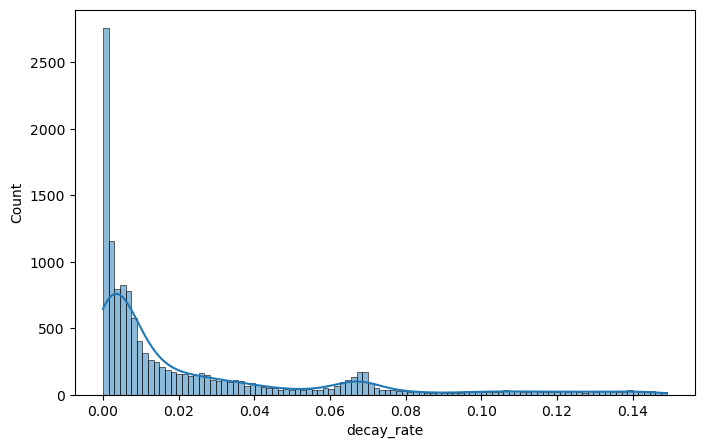

In [31]:
q95 = tle_clean['decay_rate'].quantile(0.95)

tle_trimmed = tle_clean[tle_clean['decay_rate'] <= q95]

fig, ax = plt.subplots(figsize=(8,5))
sns.histplot(tle_trimmed['decay_rate'], bins=100, kde=True, ax=ax)


